In [12]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
#imports from bayesian_network repo

SHOTS=1000
N_QUBITS = 3
QUBITS_RANGE = list(range(3))
#defining qubits and shots from bayesian_network repo

def draw_circuit(circuit, *args, filename=None):
    qml.draw_mpl(circuit)(*args)
    if(filename):
        plt.savefig(filename, bbox_inches='tight')
    plt.show()
    
def get_theta(prob):
    """
        Returns a theta angle which puts |1> in the desired probability
    """
    assert prob <= 1 and prob >= 0, "Invalid probability"
    return 2 * np.arcsin(np.sqrt(prob))

def plot(df, title, filename=None):
    labels = df['labels']
    data = df['values']
    
    plt.grid(color='gray', linestyle='--', linewidth=0.4)
    plt.bar(labels, data)
    plt.title(title)
    plt.ylabel("Results")
    plt.xticks(rotation=50)

    if(filename):
        plt.savefig(filename, bbox_inches='tight')

    plt.show()

#from bayesian_network repo

P_OilSpill = 0.1
P_NonSpill = 0.7
P_Otherspill = 0.2
#adding sample probabilities

device = qml.device("lightning.qubit", wires=N_QUBITS, shots=SHOTS)
@qml.qnode(device)
#bayesian_network repo

def circuit(status=False):
    if(status):
        qml.X(wires=[0])
        
    qml.Barrier(only_visual=True, wires=QUBITS_RANGE)

    qml.CRY(get_theta(P_OilSpill), wires=[0, 1])
    
    qml.X(wires=[0])
    qml.CRY(get_theta(P_NonSpill), wires=[0, 1])
    qml.X(wires=[0])
    
    qml.Barrier(only_visual=True, wires=QUBITS_RANGE)
    
    qml.CRY(get_theta(P_Otherspill), wires=[1,2])

    qml.X(wires=[1])
    qml.Toffoli(wires=[0,1,2])
    qml.X(wires=[1])
    
    qml.Barrier(only_visual=True, wires=QUBITS_RANGE)

    return qml.probs(wires=[1,2])



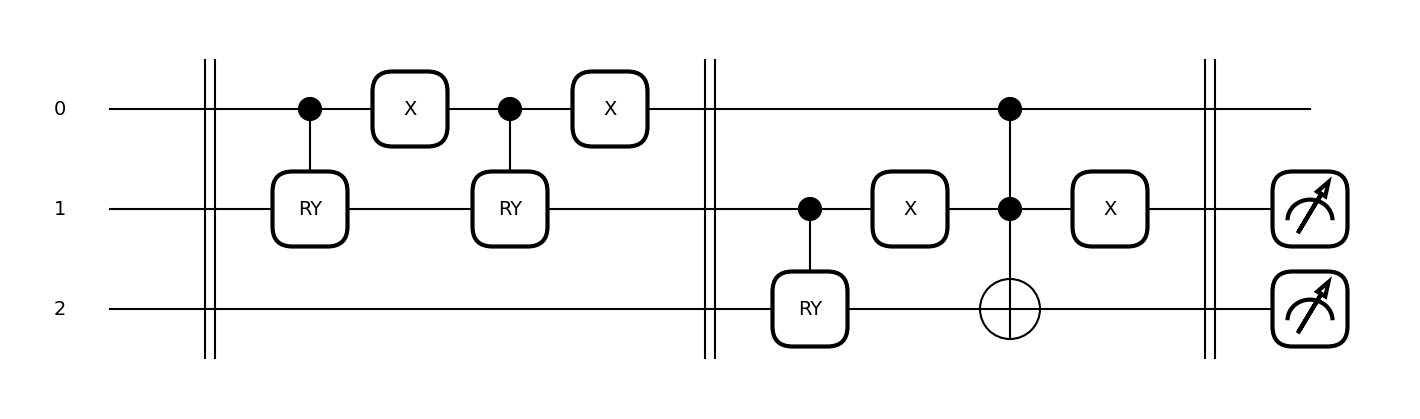

In [9]:
draw_circuit(circuit,filename="first_example.png")

In [14]:
import pandas as pd
import numpy as np
from qubayes.config import DATA_FLN


class MusicDataset:

    def __init__(self, bins, data_fln=DATA_FLN, verbose=False):
        self.data = None
        self.data_fln = data_fln
        self.bins = bins
        self.bin_names = list([])
        self.verbose = verbose
        self.load_data()
        self.bin_data()

    def load_data(self):
        data = pd.read_csv(self.data_fln)

        # drop column 'Unnamed'
        data.drop(columns=['Unnamed: 0'], axis=1, inplace=True)
        # select interesting columns
        # data = data[['artists', 'track_name', 'key', 'mode', 'tempo', 'time_signature', 'track_genre']]
        data = data.astype({'artists': 'string', 'track_name': 'string',
                            'track_genre': 'string'})
        data = data[list(self.bins.keys())]
        self.data = data
        return

    def bin_data(self):
        self.bin_names = dict()
        initial_n_tracks = self.data.shape[0]
        for key, val in self.bins.items():
            idx = np.full(self.data.shape[0], False)
            if isinstance(val, int):
                if str(self.data.dtypes[key]) == 'string':
                    data = self.get_category_by_frequency(key, val)
                else:
                    labels = [f'{key}_{i}' for i in range(val)]
                    if 'int' in str(self.data.dtypes[key]):
                        if key == 'time_signature':
                            self.data[key], bins = pd.cut(x=self.data[key], bins=np.array([1, 3, 10]),
                                                          labels=labels, retbins=True)
                        else:
                            self.data[key], bins = pd.cut(x=self.data[key], bins=val,
                                                          labels=labels, retbins=True)
                    else:
                        self.data[key], bins = pd.qcut(x=self.data[key], q=val,
                                                       labels=labels, retbins=True)
                    mapping = dict()
                    for i in range(val):
                        if key == 'mode':
                            if labels[i] == 'mode_0':
                                mapping[labels[i]] = 'minor'
                            elif labels[i] == 'mode_1':
                                mapping[labels[i]] = 'major'
                            else:
                                mapping[labels[i]] = labels[i]
                        elif key == 'time_signature':
                            if labels[i] == 'time_signature_0':
                                mapping[labels[i]] = '3'
                            elif labels[i] == 'time_signature_1':
                                mapping[labels[i]] = '4'
                            else:
                                mapping[labels[i]] = labels[i]
                        else:
                            mapping[labels[i]] = f'{key}_{bins[i]:.0f}_{bins[i+1]:.0f}'
                        # labels_new.append(f'{key}_{bins[i]:.0f}_{bins[i+1]:.0f}')

                    self.data[key] = self.data[key].map(mapping)
                    data = {}
                    for new_lab in mapping.values():
                        idx = self.data[key] == new_lab
                        data[new_lab] = sum(idx)
            else:
                if str(self.data.dtypes[key]) == 'string':
                    data = self.get_category_by_name(key, val)
                else:
                    raise NotImplementedError()
                    data = {}
                    for i in range(val):
                        data[f'{key}_{val[i]:.0f}'] = None
            self.bin_names[key] = list(data.keys())

            if str(self.data.dtypes[key]) == 'string':
                for i, bin in enumerate(data.keys()):
                    idx = idx | (self.data[key] == bin)
                self.data = self.data[idx]
        if self.verbose:
            print(f'Selected {self.data.shape[0]} tracks from {initial_n_tracks}.')
        return

    def get_category_by_frequency(self, key, n):
        c = self.data[key].value_counts().to_dict()
        i = 0
        if self.verbose:
            print(key + ':')
        temp = dict()
        for k, v in c.items():
            if self.verbose:
                print(f'- {k}: {v}')
            temp[k] = v
            i += 1
            if i >= n:
                break
        return temp

    def get_category_by_name(self, key, names):
        temp = dict()
        for d in names:
            idx = self.data[key] == d
            temp[d] = idx.sum()
            if self.verbose:
                print(f'- {d}: {idx.sum()}')
        return temp


def main():
    return


if __name__ == "__main__":
    main()

ModuleNotFoundError: No module named 'qubayes'